# Inventories
This notebook contains useful code for working with emissions inventories. Lots of work in progress stuff. 

In [1]:
#Import Packages
import sys
import pickle
import os
import pytz
import datetime
import string
import re
import pandas as pd
import numpy as np
import calendar
import pyproj
import plotly.graph_objects as go
import xesmf as xe
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature

from windrose import WindroseAxes
import xarray as xr
from pylr2 import regress2
sys.path.append('..')
import funcs.ac_funcs as ac
pd.options.mode.chained_assignment = None
#Autoreload changed local modules
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


In [2]:
#Define a function to trim an xarray dataset to an extent
def trim_ds(ds,extent_dict):
    sub_ds =  ds.sel(lat=slice(extent_dict['lat_low'],
                               extent_dict['lat_high']),
                     lon=slice(extent_dict['lon_low'],
                               extent_dict['lon_high']))
    return sub_ds

# Inventories

In [3]:
#Set the extent to which we want to clip the dataset
dataset_extent = {'lon_low':-112.1,
                  'lon_high':-111.7,
                  'lat_low':40.4,
                  'lat_high':41.0} 


## EDGAR

In [4]:
def load_edgar_nc(edgar_path,spec,emi_or_flx,year):
    if spec in ['CH4','CO2']:
        nc_folder_name = f'v8.0_FT2022_GHG_{spec}_{year}_TOTALS_{emi_or_flx}_nc'
        nc_file_name = '_'.join(nc_folder_name.split('_')[:-1]) + '.nc'
    elif spec == 'CO':
        nc_folder_name = f'EDGARv6.1_{spec}_{year}_TOTALS.0.1x0.1'
        nc_file_name = (nc_folder_name) + '.nc'

    nc_fullpath = os.path.join(edgar_path,spec,emi_or_flx,nc_folder_name,nc_file_name)
    try:    
        ds = xr.open_dataset(nc_fullpath)
    except FileNotFoundError as f:
        print(f)
        raise FileNotFoundError(f'There doesnt seem to be data for this configuration:{spec},{emi_or_flx},{year}')
    if spec == 'CO':
        ds = coord_change_360_180(ds)
        ds = ds.rename({'emi_co':'fluxes'})
        ds['fluxes'].attrs['substance'] = 'CO'

    gca_fname = nc_file_name.split('.nc')[0] + '_gca' + '.nc'
    try:
        gca_fullpath = os.path.join(edgar_path,spec,emi_or_flx,nc_folder_name,gca_fname)
        gca_ds = xr.open_dataset(gca_fullpath)
        if spec == 'CO':
            gca_ds = coord_change_360_180(gca_ds)
        ds = add_gca_to_ds(ds,gca_ds)
    except FileNotFoundError:
        print(f'No grid cell area file {gca_fullpath} found. Create with cdo to use. Returning ds without gca')
        return ds

    return ds

def coord_change_360_180(ds):
    return ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')

def add_gca_to_ds(orig_ds,gca_ds):
    orig_ds['grid_cell_area'] = gca_ds['cell_area']
    return orig_ds


In [69]:
#Load Edgar inventories
edgar_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/inventories/EDGAR/'

spec = 'CO2'
year= 2018
emi_or_flx = 'flx'

full_ds = load_edgar_nc(edgar_path,spec,emi_or_flx,year)
sub_ds = trim_ds(full_ds,dataset_extent)
if emi_or_flx == 'flx':
    sub_ds['emissions'] = (sub_ds['grid_cell_area'] * sub_ds['fluxes']) * 86400 * 365 * 1E-3 # [m2] * [kg/m2/s] * [86400s/d] *[365d/y] *[1E-3tonne/kg] = [tonne/yr]
    sub_ds['emissions'].attrs = {'substance':spec,'units':'Tonne'}

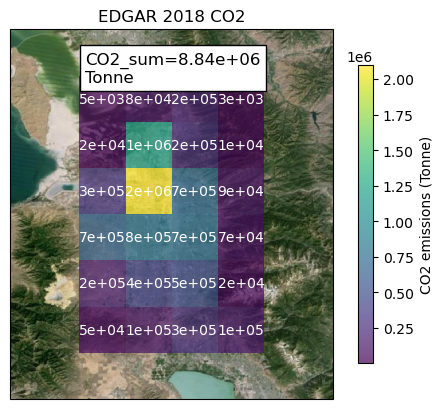

In [70]:
map_extent={'lon_low':-112.25,
            'lon_high':-111.55,
            'lat_low':40.3,
            'lat_high':41.1} 

labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure()
ax = plt.axes(projection = proj)
ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
request = cimgt.GoogleTiles(style='satellite')
scale = 10.0 # prob have to adjust this
ax.add_image(request,int(scale))
map = sub_ds['emissions'].plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False)
plt.colorbar(map,fraction=0.03,label = f"{spec} emissions ({sub_ds['emissions'].attrs['units']})")
for lat in sub_ds['emissions'].lat.values:
    for lon in sub_ds['emissions'].lon.values:
        value = sub_ds['emissions'].sel(lat=lat,lon=lon).values
        if value != value:
            continue
        plt.text(lon,lat,f'{value:.0e}',color='white',ha='center',va='center')
emissions_sum = float(sub_ds['emissions'].sum())
text = f"{spec}_sum={emissions_sum:.2e}\n{sub_ds['emissions'].attrs['units']}"
t1 = fig.text(0.45,0.77,text,fontsize = labsize)
t1.set_bbox(dict(facecolor = 'white'))
plt.title(f"EDGAR {year} {spec}")
plt.show()

In [13]:
#Load Edgar inventories
edgar_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/inventories/EDGAR/'

emi_or_flx = 'flx'
year = 2018
specs = ['CH4','CO','CO2']
edgar_sub_ds_dict = {}
edgar_sub_da_list = []
i=0
for spec in specs:
    full_ds = load_edgar_nc(edgar_path,spec,emi_or_flx,year)
    sub_ds = trim_ds(full_ds,dataset_extent)
    if emi_or_flx == 'flx':
        sub_ds['emissions'] = (sub_ds['grid_cell_area'] * sub_ds['fluxes']) * 86400 * 365 * 1E-3 # [m2] * [kg/m2/s] * [86400s/d] *[365d/y] *[1E-3tonne/kg] = [tonne/yr]
        sub_ds['emissions'].attrs = {'substance':spec,'units':'Tonne'}
    edgar_sub_ds_dict[spec] = sub_ds
    sub_da = edgar_sub_ds_dict[spec]['emissions']
    sub_da = sub_da.rename(f"{sub_da.attrs['substance']}")
    if i > 0:
        sub_da = sub_da.assign_coords({'lat':edgar_sub_da_list[0].lat,'lon':edgar_sub_da_list[0].lon})
    edgar_sub_da_list.append(sub_da)
    i+=1

edgar_combined_ds = xr.combine_by_coords(edgar_sub_da_list)

## Maasakkers EPA

Paper: https://pubs.acs.org/doi/10.1021/acs.est.3c05138  
Data: https://doi.org/10.5281/zenodo.8367082   
Code: https://github.com/USEPA/GEPA   

Flux values in original nc files are $Flux_{ch4}$ in $[{molec_{CH4}}/{cm^2s}]$. 

Convert flux values to emissions values by $Emission_{ch4} = Flux_{ch4} * grid cell area$  
Where $Emission_{ch4}$ in $[molec_{ch4}/s]$

**CONVERSION to g/yr**   

$Emissions_{ch4} [g/year] = Emissions_{ch4} [molec_{ch4}/s] * Conversion factor $

$Conversion factor = 1/6.022x10^23 [mole/molec_{ch4}] * 16.04 [g_{ch4}/mole] * 86400 [s/day] * y [days/year] $

The number of days per year (y) depends on whether the given year is a leap year. 


In [5]:
def load_epa_nc(path,year):
    fname = f'Express_Extension_Gridded_GHGI_Methane_v2_{year}.nc'
    ds = xr.open_dataset(os.path.join(path,fname))
    name_map = {k: k.replace('emi','flx') for k in ds} #in the nc file, the data variables are names "emi..." which is confusing as they are fluxes. so rename to flx...
    ds = ds.rename(name_map)
    return ds

In [6]:
#Load the Maasakkers data
epa_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/inventories/Maasakkers'
year = 2018

epa_full = load_epa_nc(epa_path,year)
epa_subset = trim_ds(epa_full,dataset_extent).sum(dim="time",keep_attrs = True)

In [7]:
#Sum variables
data_variables = list(epa_subset.keys()) #all of the vars in the nc file
emi_variables = [var for var in data_variables if var != 'grid_cell_area'] #drop the grid cell area from the variables list so we can sum
og_units = epa_subset[emi_variables[0]].attrs['units']
for emi_var in emi_variables: #check to make sure the units are the same on all of the emissions variables
    if epa_subset[emi_var].attrs['units'] != og_units:
        raise ValueError(f'The units are different in {emi_var}, so you shouldnt sum')
epa_subset['flx_ch4_sum'] = epa_subset[emi_variables].to_array().sum('variable') #sum along the emissions variables
epa_subset['flx_ch4_sum'].attrs = {'units':og_units} #add the units

#convert flux units to emissions units
# emissions[tonne/yr] = grid_cell_area[cm2] * flx_ch4[molec/cm2/s] * (1/6.022E23)[mol/molec] * 16.04[gch4/mol] * 86400[s/d] * 365[d/y] * 1E-6[tonne/g]
epa_subset['emissions'] = (epa_subset['grid_cell_area']*epa_subset['flx_ch4_sum'])*(1/6.022E23)*16.04*86400*365*1E-6  #multiply the sums by the grid cell area
epa_subset['emissions'].attrs['units'] = 'Tonnes'


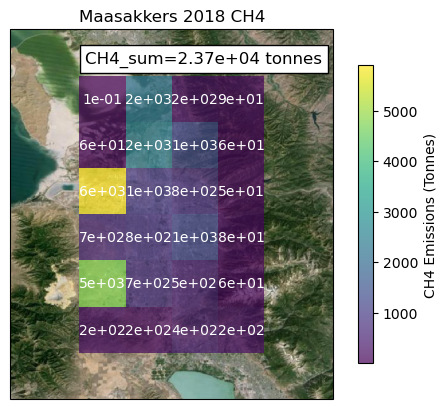

In [66]:
labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure()
ax = plt.axes(projection = proj)
map_extent={'lon_low':-112.25,
            'lon_high':-111.55,
            'lat_low':40.3,
            'lat_high':41.1} 
ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
request = cimgt.GoogleTiles(style='satellite')
scale = 10.0 # prob have to adjust this
ax.add_image(request,int(scale))

map = epa_subset['emissions'].plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False)
plt.colorbar(map,fraction=0.03,label = f'CH4 Emissions (Tonnes)')
for lat in epa_subset['emissions'].lat.values:
    for lon in epa_subset['emissions'].lon.values:
        value = epa_subset['emissions'].sel(lat=lat,lon=lon).values
        if value != value:
            continue
        plt.text(lon,lat,f'{value:.0e}',color='white',ha='center',va='center')
tot_emissions_ch4_tonne = epa_subset['emissions'].sum()
text = f'CH4_sum={tot_emissions_ch4_tonne:.2e} tonnes'
t1 = fig.text(0.45,0.81,text,fontsize = labsize)
t1.set_bbox(dict(facecolor = 'white'))

plt.title(f"Maasakkers {year} CH4")
plt.show()

## NOAA CSL

### Processed NC

In [ ]:
def get_satsunwkd(year,month):
    '''Gets the number of saturdays, sundays and weekdays in a given month+year
    
    Args:
    year (int) : the year
    month (int) : the month, as an integer
    
    Returns:
    sat_count (int) : number of saturdays
    sun_count (int) : number of sundays
    wkd_count (int) : number of weekdays
    '''

    num_days_in_month = calendar.monthrange(year,month)[1]
    month_str = f'{month:02d}'

    dow_ints = list(pd.date_range(start=f'{year}-{month_str}-01',end=f'{year}-{month_str}-{num_days_in_month}').weekday)
    sat_count = len([ dow for dow in dow_ints if dow == 5 ])
    sun_count = len([ dow for dow in dow_ints if dow == 6 ])
    wkd_count = len([ dow for dow in dow_ints if dow < 5 ])
    return sat_count,sun_count,wkd_count

In [9]:
csl_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/inventories/NOAA_CSL'
year = 2019
month = 1
month_str = f'{month:02d}'

day_type = 'WKD'
full_fname = os.path.join(csl_path,f'{day_type}_nc',f'CO2_{day_type}_{year}_{month_str}_NOAA_CSL_SLV_lon.lat.nc')
csl_xr = xr.open_dataset(full_fname)
# csl_xr = trim_ds(csl_xr,dataset_extent)
# csl_xr = csl_xr * 3600
# csl_xr = csl_xr.sum(dim='hour_UTC')


In [ ]:
csl_xr['co2_sum'] = csl_xr[list(csl_xr.keys())].to_array().sum('variable') #sum along the emissions variables

In [ ]:
#co2 sum is in umol/m2/d. therefore:
# [tonne/yr] = [umol/m2/d] * 1E-6 [mol/umol] * 365 [d/y] * 44 [g/mol] * 1E-6 [tonne/g] * 2259838224 [m2]
(csl_xr['co2_sum']* 2252456065.6/(40*60) * 1E-6 * 365 * 44 * 1E-6).sum()

In [ ]:
csl_xr['co2_sum'].mean() / 1E6 * 365 * 16 /1E6 * 2259838224

In [11]:
csl_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/inventories/NOAA_CSL'
year = 2019
month = 1
month_str = f'{month:02d}'

day_type = 'WKD'
full_fname = os.path.join(csl_path,f'{day_type}_nc',f'CO2_{day_type}_{year}_{month_str}_NOAA_CSL_SLV_lon.lat.nc')
csl_xr = xr.open_dataset(full_fname)
csl_xr = trim_ds(csl_xr,dataset_extent)
csl_xr = csl_xr * 60 * 60
csl_xr = csl_xr.sum(dim='hour_UTC')
csl_xr = csl_xr *86400
summed_csl = xr.full_like(csl_xr['CO2_EGU_point'],0)
for data_var in list(csl_xr.data_vars):
    summed_csl = summed_csl + csl_xr[data_var]

# summed_csl.mean() #* 86400 / 1E6 * 365 * 16 /1E6 * 2259838224 #/ 1E6 * 365 * 16 /1E6 * 2259838224

In [ ]:
csl_xr.sum()

In [13]:
# Load CO2 csl for weekday in jan
co2_wkd_csl = xr.open_dataset('/uufs/chpc.utah.edu/common/home/lin-group10/HKH/CLS_NOAA_Emissions/Emission_Eval/NCDF_Grid_SLV/WKD_nc/CO2_WKD_2019_01_NOAA_CSL_SLV_lon.lat.nc')
co2_wkd_csl = trim_ds(co2_wkd_csl,dataset_extent)
co2_wkd_csl_hour = co2_wkd_csl*3600
co2_csl_timesum = co2_wkd_csl_hour.sum(dim='hour_UTC')
summed_csl_da = xr.full_like(co2_csl_timesum['CO2_EGU_point'],0)
for data_var in list(co2_csl_timesum.data_vars):
    summed_csl_da = summed_csl_da + co2_csl_timesum[data_var]

In [14]:
co2_csl_timemean = co2_wkd_csl.mean(dim='hour_UTC')
summed_csl_da = xr.full_like(co2_csl_timemean['CO2_EGU_point'],0)
for data_var in list(co2_csl_timemean.data_vars):
    summed_csl_da = summed_csl_da + co2_csl_timemean[data_var]

In [ ]:
summed_csl_da.mean() 

In [ ]:
x = 0
for data_var in list(co2_csl_timemean.data_vars):
    x+= float(co2_csl_timemean[data_var].mean())
x * 86400 / 1E6 * 365 * 16 /1E6 * 2259838224


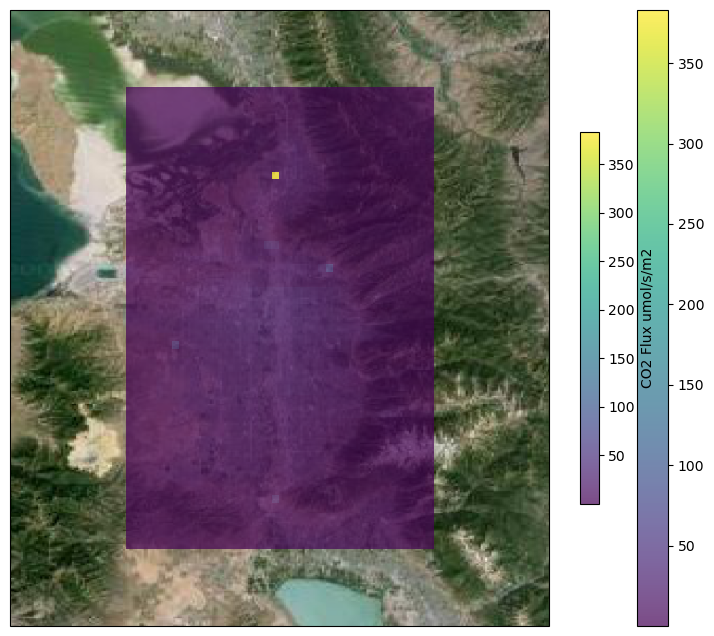

In [17]:
#Plot it

map_extent={'lon_low':-112.25,
            'lon_high':-111.55,
            'lat_low':40.3,
            'lat_high':41.1} 
labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
request = cimgt.GoogleTiles(style='satellite')
scale = 9.0 # prob have to adjust this
ax.add_image(request,int(scale))

map = summed_csl_da.plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis')#,add_colorbar=False,vmax = 2000000)
plt.colorbar(map,fraction=0.03,label ='CO2 Flux umol/s/m2')
plt.show()

### Raw EI

In [60]:


nc_fpath = '/uufs/chpc.utah.edu/common/home/lin-group10/HKH/Public/NOAA_CSL_Raw_Data/EI_2019_01/Area_no_OG/weekdy/TotlArea_noOG_00to12Z.nc'
#"/uufs/chpc.utah.edu/common/home/lin-group10/HKH/Public/NOAA_CSL_Raw_Data/EI_2019_01/Area_OG/weekdy/AreaFOGnei17_00to12Z.nc"
ds = xr.open_dataset(nc_fpath)
ch4_t1 = ds.isel({'Time':1})['HC01']

In [61]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:   (Time: 12, south_north: 1008, west_east: 1332)
Coordinates:
    XLAT      (south_north, west_east) float32 5MB ...
    XLONG     (south_north, west_east) float32 5MB ...
Dimensions without coordinates: Time, south_north, west_east
Data variables: (12/81)
    CO        (Time, south_north, west_east) float32 64MB ...
    CO2       (Time, south_north, west_east) float32 64MB ...
    HC01      (Time, south_north, west_east) float32 64MB ...
    HC02      (Time, south_north, west_east) float32 64MB ...
    HC03      (Time, south_north, west_east) float32 64MB ...
    HC04      (Time, south_north, west_east) float32 64MB ...
    ...        ...
    PM18      (Time, south_north, west_east) float32 64MB ...
    PM19      (Time, south_north, west_east) float32 64MB ...
    PM25-PRI  (Time, south_north, west_east) float32 64MB ...
    SO2       (Time, south_north, west_east) float32 64MB ...
    Times     (Time) |S19 228B ...
    VOC       (Time, south_north, west_east) float32 64MB ...
Attributes: (12/29)
    WEST-EAST_GRID_DIMENSION:        1333
    SOUTH-NORTH_GRID_DIMENSION:      1009
    DX:                              4000.0
    DY:                              4000.0
    WEST-EAST_PATCH_START_UNSTAG:    1
    WEST-EAST_PATCH_END_UNSTAG:      1332
    ...                              ...
    POLE_LAT:                        90.0
    POLE_LON:                        0.0
    MAP_PROJ:                        1
    MAP_PROJ_CHAR:                   Lambert Conformal
    TITLE:                           netcdf4 FIVE emission file, brian.mcdona...
    history:                         Sun Jan 24 10:05:42 2021: ncks -d Time,0...

In [16]:
class inputs():
    # Define all variables related to input and output and regions
    # File names to read in
    # fn_base1 = 'wrfchemi_00z_d01'
    # fn_base2 = 'wrfchemi_12z_d01'
    # fn_ext = '.nc'
    
    # file name for save out
    # fn_out = 'regridded.nc'
    
    # input_dir = '/data/colharkins/EI_noaa/VCP/VCP_EI/'
    # out_dir = '/data/colharkins/EI_noaa/VCP/VCP_EI/'
    # base_dir = '/data/colharkins/EI_noaa/VCP/VCP_EI/'
    
    # days = ['weekdy','satdy','sundy']
    # years = [2011]
    # months = {'Month01':1,'Month02':2,
    #     'Month03':3,'Month04':4,
    #     'Month05':5,'Month06':6,
    #     'Month07':7,'Month08':8,
    #     'Month09':9,'Month10':10,
    #     'Month11':11,'Month12':12}

        # Converting Everything into kg/m^2/hour 
    MW = {'E_ALD': 44.05, 'E_CH4': 16,'E_CO' : 28,'E_CO2' : 44,'E_CSL' : 106.16,'E_ETH' : 28.05,
             'E_HC3': 44.1,'E_HC5' : 58.12,'E_HC8' : 58.12,'E_HCHO' : 30.031, 'E_HONO': 47, 'E_ISO': 68.12,
             'E_KET': 58.08, 'E_NH3': 17, 'E_NO': 30.01, 'E_NO2': 46.0055, 'E_OL2': 28.05, 'E_OLI': 42.08,
             'E_OLT' : 42.08,'E_ORA2': 74.08, 'E_SO2': 64, 'E_TERP': 136.23,'E_TOL': 92.14, 'E_UNID': 128.18,'E_XYL': 106.16}
    
    Aerosols = ['E_EC', 'E_NO3', 'E_ORG', 'E_PM25', 'E_PM10', 'E_SO4']
    
    reuse_weight_file = False

In [48]:
# Courtesy of Colin Harkins @ NOAA
def makeregridder(ds,var_name):
    #Calculating Projection from WRF LCC to WRF lat long space 
    wrf_proj = pyproj.Proj(proj='lcc', # projection type: Lambert Conformal Conic
                           lat_1=ds.TRUELAT1, lat_2=ds.TRUELAT2, # Cone intersects with the sphere
                           lat_0=ds.MOAD_CEN_LAT, lon_0=ds.STAND_LON, # Center point
                           a=6370000, b=6370000) # This is it! The Earth is a perfect sphere
    
    # Calculating the Projection from WRF lat long to WGS lat long
    # Easting and Northings of the domains center point
    wgs_proj = pyproj.Proj(proj='latlong', datum='WGS84')
    e, n = pyproj.transform(wgs_proj, wrf_proj, ds.CEN_LON, ds.CEN_LAT)
    
    # Grid parameters
    dx, dy = ds.DX, ds.DY
    nx, ny = ds.dims['west_east'], ds.dims['south_north']
    # Down left corner of the domain
    x0 = -(nx-1) / 2. * dx + e
    y0 = -(ny-1) / 2. * dy + n

    # 2d grid
    xx, yy = np.meshgrid(np.arange(nx) * dx + x0, np.arange(ny) * dy + y0)
    
    # Calculating the boundary X-Y Coordinates
    x_b, y_b = np.meshgrid(np.arange(nx+1) * dx + x0 -dx/2, np.arange(ny+1) * dy + y0 -dy/2)

    #Transformation of Center X-Y to Center Lat-Lon
    xc, yc = pyproj.transform(wrf_proj, wgs_proj, xx, yy)
    
    #Transformation of Boundary X-Y to Center Lat_Lon
    x_bc, y_bc = pyproj.transform(wrf_proj, wgs_proj, x_b, y_b)
    
    #Pulling out 1 variable to calc transformation with
    dr = ds[var_name][0,:,:]
    dr_int = dr.to_dataset(name=var_name)
    
    #Grid Spacing For prior grid
    in_coords = {'lat': dr_int['XLAT'].values, #Center Point Spacing Lat
                        'lon': dr_int['XLONG'].values, #Center Point Spacing Lon
                        'lat_b': y_bc, # Boundary Spacing Lat 
                        'lon_b': x_bc, # Boundary Spacing Lon
                       }
    
    #Grid Spacing For New Grid
    out_coords = {  'lat': np.arange(23, 54, 0.1), #Center Point Spacing Lat
                    'lon': np.arange(-126, -63, 0.1), #Center Point Spacing Lon
                    'lat_b': np.arange(22.95, 54.05, 0.1), # Boundary Spacing Lat 
                    'lon_b': np.arange(-126.05, -62.95, 0.1), # Boundary Spacing Lon
                }
    out_coords = {  'lat': np.arange(19, 58, 0.1), #Center Point Spacing Lat
                    'lon': np.arange(-138, -59, 0.1), #Center Point Spacing Lon
                    'lat_b': np.arange(18.95, 58.05, 0.1), # Boundary Spacing Lat 
                    'lon_b': np.arange(-138.05, -58.95, 0.1), # Boundary Spacing Lon
                }
    # Constructing Regridder
    regridder = xe.Regridder(in_coords, out_coords, method='conservative',reuse_weights=inputs.reuse_weight_file)
    return regridder, xc, yc


def reformat_ds(ds, lonc, latc):
    # Renaming Files to proper Names, setting coordinates
    ds = ds.rename({'south_north':'y'})
    ds = ds.rename({'west_east':'x'})
    ds = ds.assign({'lat': (['y', 'x'], latc),'lon': (['y', 'x'], lonc)})
    ds = ds.set_coords('lat')
    ds = ds.set_coords('lon')
    ds = ds.set_coords('Times')
    return ds

def convert_units(ds_out):
    ds_out_convert = ds_out
    # Convert other units
    # originally in moles/km^2/hour, converting to kg/m^2/s
    for key in inputs.MW:
        if key not in list(ds_out_convert.keys()):
            continue
        ds_out_convert[key] = ds_out[key]*inputs.MW[key]/3600/1000000/1000 # 1hour/3600s 1m2/1e6km2 1kg/1000g
        
    # convert aerosol units
    #for word in inputs.Aerosols:
    #    ds_out_convert[word] = ds_out[word]/1000000000 # convert from ug/m^3 m/s to kg/m^2/s by * 1e9
    return ds_out_convert
    
# End convert_units

def reformat_ds_out(ds_out_convert,day_half):
    #More formatting to COARDS
    #Renaming Dimentions 
    ds_out_convert = ds_out_convert.rename({'Time':'time'})
    ds_out_convert = ds_out_convert.rename({'Times':'time'})# rename coordinate of time
    
    ## Changing time to be what it should be for 7/4/2018
    #ds_out_convert['time'] = [162216, 162217, 162218, 162219, 162220, 162221, 162222, 162223, 162224, 162225, 162226, 162227]
    if day_half == '00z':
        ds_out_convert['time'] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    elif day_half == '12z':
        ds_out_convert['time'] = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
        
    # # Setting time Coordinate Attributes
    ds_out_convert['time'].attrs={'long_name': ('time'), 'units': ('hours since 2010-07-01 00:00:00 GMT'), 'calendar' : ('standard'), 'axis' : ('T')}

    # Setting Lat/lon Coordinate Attributes
    ds_out_convert['lat'].attrs={'long_name': ('Latitude'), 'units': ('degrees_north'),'axis' : ('Y')}
    ds_out_convert['lon'].attrs={'long_name': ('Longitude'), 'units': ('degrees_east'),'axis' : ('X')}

    ds_out_convert = ds_out_convert.fillna(0)
    
    # Adding Variable Attributes to all
    # ds_out_convert['E_CH4'].attrs={'long_name': ('Methane'), 'units': ('kg/m2/s')}
    # ds_out_convert['E_CO'].attrs={'long_name': ('CO'), 'units': ('kg/m2/s')}
   
    return ds_out_convert

def combine_dayhalves(ds_00z, ds_12z):
    merger = xr.concat([ds_00z, ds_12z], dim='time')
    # merger['time'].astype(int)
    merger['time'].attrs={'long_name': ('time'), 'units': ('hours since 2010-07-01 00:00:00 GMT'), 'calendar' : ('standard'), 'axis' : ('T')}
    return merger

def set_output_attrs(ds_out):
    for ii in ds_out.data_vars:
        ds_out[ii].encoding={'dtype': 'float32', 'chunksizes': (1,1,310,630),'zlib': True, 'complevel': 1}
        #ds_out[ii].attrs={'description': (ds[ii].attrs['description'])}
        #print(ds_out[ii].encoding)
    # setting global attributes
    ds_out.attrs['Title']='Emission inventory Regridded from WRF to Lat Lon grid'
    ds_out.attrs['Conventions']='COARDS'
    ds_out.attrs['History']=''
    #del ds_out_convert.attrs['global_attributes']
    return ds_out

In [49]:
hrz = {'00z':{
            'full_filepath':"/uufs/chpc.utah.edu/common/home/lin-group10/HKH/Public/NOAA_CSL_Raw_Data/EI_2019_01/Area_OG/weekdy/AreaFOGnei17_00to12Z.nc",
            'ds':None 
        },  
        '12z':{
            'full_filepath':'/uufs/chpc.utah.edu/common/home/lin-group10/HKH/Public/NOAA_CSL_Raw_Data/EI_2019_01/Area_OG/satdy/AreaFOGnei17_12to24Z.nc',
            'ds':None 
        }}
var_name = 'HC01'

ds_example = xr.open_dataset(hrz['00z']['full_filepath'])
regridder, lonc, latc = makeregridder(ds,var_name)

for key, hz in hrz.items():
    ds_in = xr.open_dataset(hz['full_filepath'],chunks={'Time': 1})
    ds_in = reformat_ds(ds_in,lonc,latc)
    ds_out = regridder(ds_in)
    ds_out = convert_units(ds_out)
    ds_out = reformat_ds_out(ds_out,'00z')
    hrz[key]['ds'] = ds_out


#ds_out = combine_dayhalves(ds_out_00z, ds_out_12z)
#ds_out = set_output_attrs(ds_out)    



In [54]:
day_ds = combine_dayhalves(hrz['00z']['ds'], hrz['12z']['ds'])
day_ds = set_output_attrs(day_ds)    

In [57]:
sub_ds = trim_ds(day_ds,dataset_extent)

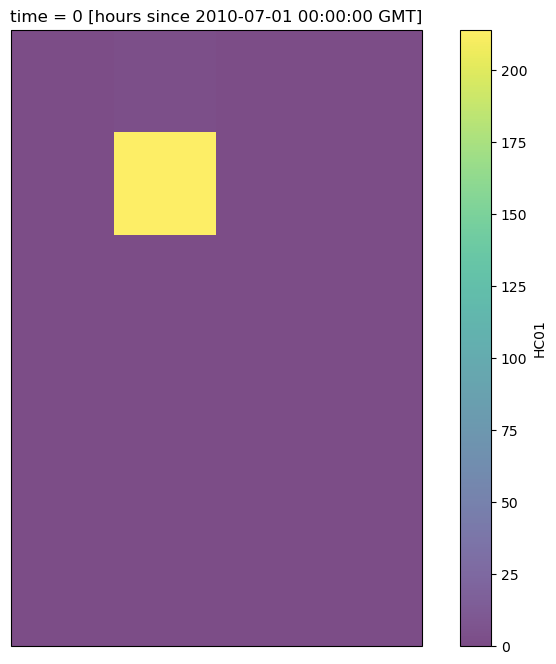

In [59]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
sub_ds[var_name][0,:,:].plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()

In [18]:
fn_00z = dir_name + inputs.fn_base1
fn_12z = dir_name + inputs.fn_base2

print('Reading Files:   ')
print(fn_00z)
print(fn_12z)

ds_in_00z = xr.open_dataset(fn_00z,chunks={'Time': 1,'emissions_zdim': 1})
ds_in_12z = xr.open_dataset(fn_12z,chunks={'Time': 1,'emissions_zdim': 1})

ds_in_00z = reformat_ds(ds_in_00z,lonc,latc)
ds_in_12z = reformat_ds(ds_in_12z,lonc,latc)

# Call Regridder on the full Dataset
ds_out_00z = regridder(ds_in_00z)
ds_out_12z = regridder(ds_in_12z)

ds_out_00z = convert_units(ds_out_00z)
ds_out_12z = convert_units(ds_out_12z)

ds_out_00z = reformat_ds_out(ds_out_00z,'00z')
ds_out_12z = reformat_ds_out(ds_out_12z,'12z')

ds_out = combine_dayhalves(ds_out_00z, ds_out_12z)

ds_out = set_output_attrs(ds_out)    

out_dir = inputs.out_dir  + str(year) + '/' + month + '/' + day + '/'

# Save out the File to NetCDF
ds_out.to_netcdf(out_dir + inputs.fn_out,format='netCDF4',engine='netcdf4')



# for year in inputs.years:
#     for month in inputs.months.keys():
#         for day in inputs.days:
#             dir_name = inputs.base_dir  + str(year) + '/' + month + '/' + day + '/'
#             fn_00z = dir_name + inputs.fn_base1
#             fn_12z = dir_name + inputs.fn_base2
            
#             print('Reading Files:   ')
#             print(fn_00z)
#             print(fn_12z)
            
#             ds_in_00z = xr.open_dataset(fn_00z,chunks={'Time': 1,'emissions_zdim': 1})
#             ds_in_12z = xr.open_dataset(fn_12z,chunks={'Time': 1,'emissions_zdim': 1})

#             ds_in_00z = reformat_ds(ds_in_00z,lonc,latc)
#             ds_in_12z = reformat_ds(ds_in_12z,lonc,latc)
            
#             # Call Regridder on the full Dataset
#             ds_out_00z = regridder(ds_in_00z)
#             ds_out_12z = regridder(ds_in_12z)
            
#             ds_out_00z = convert_units(ds_out_00z)
#             ds_out_12z = convert_units(ds_out_12z)
            
#             ds_out_00z = reformat_ds_out(ds_out_00z,'00z')
#             ds_out_12z = reformat_ds_out(ds_out_12z,'12z')
            
#             ds_out = combine_dayhalves(ds_out_00z, ds_out_12z)
            
#             ds_out = set_output_attrs(ds_out)    
            
#             out_dir = inputs.out_dir  + str(year) + '/' + month + '/' + day + '/'
            
#             # Save out the File to NetCDF
#             ds_out.to_netcdf(out_dir + inputs.fn_out,format='netCDF4',engine='netcdf4')
# #End main

## Ratios

In [47]:
molar_masses = {'CH4':16.04,'CO2':44.01,'CO':28.01}
ratio_details = {'CH4/CO2':{'specs':['CH4','CO2'],'permil':True},
             'CH4/CO':{'specs':['CH4','CO'],'permil':False},
             'CO/CO2':{'specs':['CO','CO2'],'permil':True}}
quantile = 0.25

### Edgar:Edgar

In [48]:
for ratio_id in ratio_details.keys():
    specs = ratio_details[ratio_id]['specs']
    numerator_spec = specs[0]
    denominator_spec = specs[1]
    tot_num = float(edgar_combined_ds[f'{numerator_spec}'].sum())
    tot_den = float(edgar_combined_ds[f'{denominator_spec}'].sum())
    ratio_details[ratio_id]['tot_ratio_edgaredgar'] = tot_num/tot_den * molar_masses[denominator_spec]/molar_masses[numerator_spec]
    above_quantile_ds_numerator = edgar_combined_ds[numerator_spec].where(edgar_combined_ds[numerator_spec]>edgar_combined_ds[numerator_spec].quantile(quantile))
    above_quantile_ds_denominator = edgar_combined_ds[denominator_spec].where(edgar_combined_ds[denominator_spec]>edgar_combined_ds[denominator_spec].quantile(quantile))

    edgar_combined_ds[ratio_id] = above_quantile_ds_numerator/above_quantile_ds_denominator * molar_masses[denominator_spec]/molar_masses[numerator_spec]

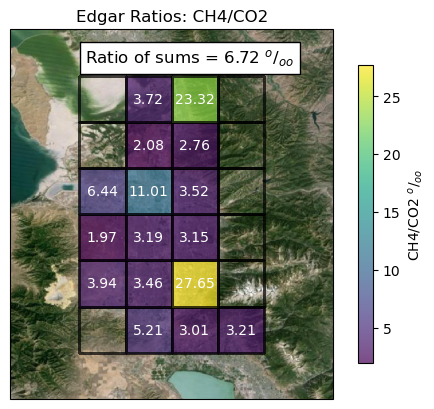

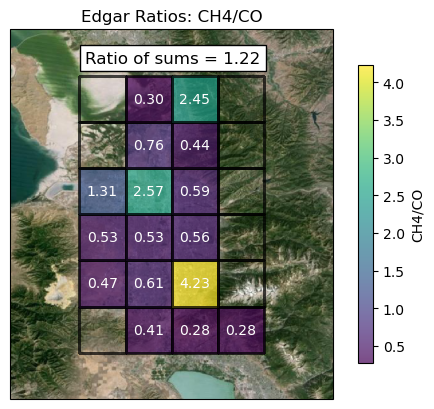

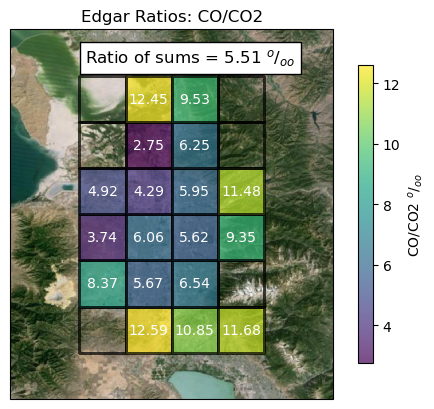

In [49]:
ratio_ids = list(ratio_details.keys())
for ratio_id in ratio_ids:
    da = edgar_combined_ds[ratio_id]
    total_ratio = ratio_details[ratio_id]['tot_ratio_edgaredgar']
    permil = ratio_details[ratio_id]['permil']
    if permil:
        da = da*1000
        total_ratio = total_ratio*1000

    map_extent={'lon_low':-112.25,
                'lon_high':-111.55,
                'lat_low':40.3,
                'lat_high':41.1} 
    labsize = 12
    proj = ccrs.PlateCarree()
    fig = plt.figure()
    ax = plt.axes(projection = proj)
    ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
    request = cimgt.GoogleTiles(style='satellite')
    scale = 10.0 # prob have to adjust this
    ax.add_image(request,int(scale))

    map = da.plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False,edgecolors = 'black')#,vmin=0,vmax = 10)
    colorbar_label = ratio_id
    if permil:
        colorbar_label = ratio_id+" $^o/_{oo}$"
    plt.colorbar(map,fraction=0.03,label = colorbar_label)

    for lat in da.lat.values:
        for lon in da.lon.values:
            value = da.sel(lat=lat,lon=lon).values
            if value != value:
                continue
            plt.text(lon,lat,f'{value:.2f}',color='white',ha='center',va='center')



    text = f"Ratio of sums = {total_ratio:.2f}"
    if permil:
        text = text+ " $^o/_{oo}$"
    t1 = fig.text(0.45,0.81,text,fontsize = labsize)
    t1.set_bbox(dict(facecolor = 'white'))
    plt.title(f"Edgar Ratios: {ratio_id}")
    plt.show()

### EPA:Edgar

In [82]:
epa_subset_emissions = epa_subset.rename({'emissions':'CH4'})
epa_edgar_ratio_das = []
for ratio_id in ['CH4/CO2','CH4/CO']:
    specs = ratio_details[ratio_id]['specs']
    numerator_spec = specs[0]
    denominator_spec = specs[1]
    tot_num = float(epa_subset_emissions[f'{numerator_spec}'].sum())
    tot_den = float(edgar_combined_ds[f'{denominator_spec}'].sum())
    ratio_details[ratio_id]['tot_ratio_epaedgar'] = tot_num/tot_den * molar_masses[denominator_spec]/molar_masses[numerator_spec]
    above_quantile_ds_numerator = epa_subset_emissions[numerator_spec].where(epa_subset_emissions[numerator_spec]>epa_subset_emissions[numerator_spec].quantile(quantile))
    above_quantile_ds_denominator = edgar_combined_ds[denominator_spec].where(edgar_combined_ds[denominator_spec]>edgar_combined_ds[denominator_spec].quantile(quantile))
    above_quantile_ds_denominator = above_quantile_ds_denominator.assign_coords({'lat':above_quantile_ds_numerator.lat,'lon':above_quantile_ds_numerator.lon})

    epa_edgar_ratio_da = above_quantile_ds_numerator/above_quantile_ds_denominator * molar_masses[denominator_spec]/molar_masses[numerator_spec]
    epa_edgar_ratio_da = epa_edgar_ratio_da.rename(ratio_id)
    epa_edgar_ratio_das.append(epa_edgar_ratio_da)
epa_edgar_ratio_ds = xr.combine_by_coords(epa_edgar_ratio_das)

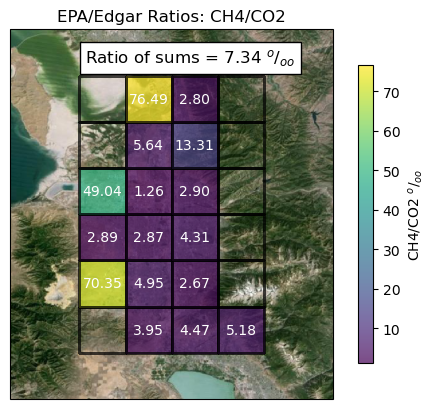

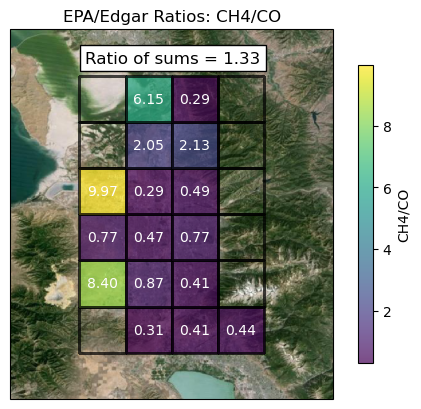

In [83]:
for ratio_id in ['CH4/CO2','CH4/CO']:
    da = epa_edgar_ratio_ds[ratio_id]
    total_ratio = ratio_details[ratio_id]['tot_ratio_epaedgar']
    permil = ratio_details[ratio_id]['permil']
    if permil:
        da = da*1000
        total_ratio = total_ratio*1000

    map_extent={'lon_low':-112.25,
                'lon_high':-111.55,
                'lat_low':40.3,
                'lat_high':41.1} 
    labsize = 12
    proj = ccrs.PlateCarree()
    fig = plt.figure()
    ax = plt.axes(projection = proj)
    ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
    request = cimgt.GoogleTiles(style='satellite')
    scale = 10.0 # prob have to adjust this
    ax.add_image(request,int(scale))

    map = da.plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False,edgecolors = 'black')#,vmin=0,vmax = 10)
    colorbar_label = ratio_id
    if permil:
        colorbar_label = ratio_id+" $^o/_{oo}$"
    plt.colorbar(map,fraction=0.03,label = colorbar_label)

    for lat in da.lat.values:
        for lon in da.lon.values:
            value = da.sel(lat=lat,lon=lon).values
            if value != value:
                continue
            plt.text(lon,lat,f'{value:.2f}',color='white',ha='center',va='center')



    text = f"Ratio of sums = {total_ratio:.2f}"
    if permil:
        text = text+ " $^o/_{oo}$"
    t1 = fig.text(0.45,0.81,text,fontsize = labsize)
    t1.set_bbox(dict(facecolor = 'white'))
    plt.title(f"EPA/Edgar Ratios: {ratio_id}")
    plt.show()